In [1]:
import crispr_hmm
from Bio import SeqIO
import random
import numpy as np
from Bio import pairwise2
import matplotlib.pyplot as plt

ref = "TAGGGCCTTCGCGCACCTCATGGAATCCCTTCTGCAGCACCTGGATCGCTTTTCCGAGCTTC"
data = SeqIO.parse("./data/base_editor/SRR3305545_trim2.fastq","fastq")
counter = {}
for record in data:
    t = record.seq._data.decode()
    if t not in counter:
        counter[t] = 1
    else:
        counter[t] += 1
len(counter)

/homes8/jingyuan/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


1149

In [9]:
counter_filtered = {key: value for key, value in counter.items() if value >= 2 and 
                    key.count("N")<1 and key!=ref}
len(counter_filtered)

305

In [3]:
top_sequences = dict(sorted(counter_filtered.items(), key=lambda x: x[1], reverse=True))
top_sequences

{'TAGGGCCTTCGCGCACCTCATGGAATTTTTTCTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 2977,
 'TAGGGCCTTCGCGCACCTCATGGAATTTTTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 2553,
 'TAGGGCCTTCGCGCACCTCATGGAATTCTTTCTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 485,
 'TAGGGCCTTCGCGCACCTGGATCGCTTTTCCGAGCTTC': 472,
 'TAGGGCCTTCGCGCACCTCATGGAATTTTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 401,
 'TAGGGCCTTCGCGCACCTCATGGAATTCCTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 304,
 'TAGGGCCTTCGCGCACCTCATGGAATTGTTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 250,
 'TAGGGCCTTCGCGCACCTTATGGAATTTTTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 195,
 'TAGGGCCTTCGCGCACCTCATGGAATTTCTTCTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 173,
 'TAGGGCCTTCGCGCACCTCATGGAATTTCTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 166,
 'TAGGGCCTTCGCGCACCTCATGGAATTTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 156,
 'TAGGGCCTTCGCGCACCTCATGGAATTTGTTTTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 153,
 'TAGGGCCTTCGCGCACCTCATGGAATTGTTTCTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 149,
 'TAGGGCCTTCGCGCACCTCATGGAATTTATTCTGCAGCACCTGGATCGCTTTTCCGAGCTTC': 146,
 'TAGGGCCTTCGCGCA

In [4]:
sequences_list = [key for key, value in top_sequences.items() for _ in range(value)]
len(sequences_list)

14184

In [5]:
model = crispr_hmm.hmm_model(ref)
model.estimate_param(sequences_list, ncores=5)

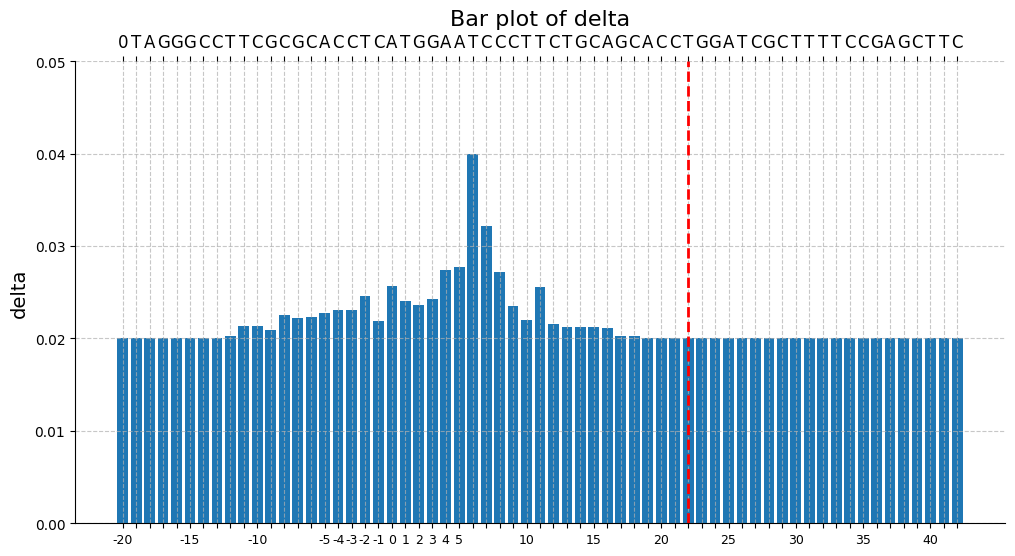

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get the y-axis values
y_values = getattr(model, "delta")

# Define a pretty shade of blue
pretty_blue = "#1f77b4"

param = "delta"
fig, ax = plt.subplots(figsize=(12, 6))
pos = [j for j in range(model.n + 1)]

# Use the pretty shade of blue for the bars
ax.bar(pos, y_values, color=pretty_blue)

pos_tick = [str(i-20) if abs(i-20)<6 or (i-20) % 5 ==0 \
            else "" for i in range(model.n+1)]
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=9)
ax.set_ylim((0, 0.05))

ax.set_ylabel("%s" % param, fontsize=14)
ax.set_title("Bar plot of %s" % param, fontsize=16)

# Add a thin vertical grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
bar = ["0"] + [j for j in model.reference_sequence]
ax2.set_xticks(pos)
ax2.set_xticklabels(bar, fontsize=12)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a vertical line at x-position 5
ax.axvline(x=42, color='red', linestyle='--', linewidth=2)

# Show the plot
plt.show()


In [10]:
filtered_seqs = [key for key, value in counter_filtered.items() for _ in range(value)]
len(filtered_seqs)

14184

In [11]:
import csv

NW_result = []
random.seed(10)
for t in filtered_seqs:
    align = pairwise2.align.globalms(ref,
                    t,
                    2,
                    -2,
                    -10,
                    -0.1,
                    penalize_end_gaps=1)
    random_alignment = random.sample(align,1)
    NW_result.append(random_alignment[0][:3])
len(NW_result)

with open("./output/NW_base_editor_result.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["aligned_ref","aligned_read","score"])
    for row in NW_result:
        writer.writerow(row)

In [12]:
HMM_result = [] 

for r in model.viterbi(filtered_seqs,ncores=10):
    HMM_result.append(r)
len(HMM_result)

with open("./output/HMM_base_editor_result.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["aligned_ref","aligned_read","score"])
    for row in HMM_result:
        writer.writerow(row)

In [15]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

i = 1
seq_records = []
for read in filtered_seqs:
    seq_record = SeqRecord(
        Seq(read),
        id=str(i),
        description='',
        letter_annotations={'phred_quality': [35 for _ in read]}
    )
    seq_records.append(seq_record)
    i += 1


output_fastq = './data/base_editor/SRR3305545_filtered.fastq'
with open(output_fastq, 'w') as out_handle:
    SeqIO.write(seq_records, out_handle, 'fastq')